In [20]:
!git clone https://github.com/Pakohp88/Equipo1_mlops.git

Cloning into 'Equipo1_mlops'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 29 (delta 2), reused 24 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 5.22 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [23]:
%cd /content/Equipo1_mlops

/content/Equipo1_mlops


In [24]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [25]:
!git checkout -b feature/eda

Switched to a new branch 'feature/eda'


In [50]:
import os
import re
import math
import json
import joblib
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Tuple, List, Dict, Optional
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from typing import List, Dict, Optional

**Carga y revisión inicial del dataset**

In [32]:
import pandas as pd

# Cargar el dataset (tu avance)
df = pd.read_csv('data/raw/turkish_music_emotion_modified.csv')

# Mostrar forma y columnas
print("Dimensiones del dataset:", df.shape)
print("\nColumnas del dataset:\n", list(df.columns))

# Tipos de datos y valores nulos (vista rápida)
print("\nInformación general del dataset:")
print(df.info())

# Primeras filas
print("\nVista previa:")
display(df.head())

# Conteo de valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

Dimensiones del dataset: (408, 52)

Columnas del dataset:
 ['Class', '_RMSenergy_Mean', '_Lowenergy_Mean', '_Fluctuation_Mean', '_Tempo_Mean', '_MFCC_Mean_1', '_MFCC_Mean_2', '_MFCC_Mean_3', '_MFCC_Mean_4', '_MFCC_Mean_5', '_MFCC_Mean_6', '_MFCC_Mean_7', '_MFCC_Mean_8', '_MFCC_Mean_9', '_MFCC_Mean_10', '_MFCC_Mean_11', '_MFCC_Mean_12', '_MFCC_Mean_13', '_Roughness_Mean', '_Roughness_Slope', '_Zero-crossingrate_Mean', '_AttackTime_Mean', '_AttackTime_Slope', '_Rolloff_Mean', '_Eventdensity_Mean', '_Pulseclarity_Mean', '_Brightness_Mean', '_Spectralcentroid_Mean', '_Spectralspread_Mean', '_Spectralskewness_Mean', '_Spectralkurtosis_Mean', '_Spectralflatness_Mean', '_EntropyofSpectrum_Mean', '_Chromagram_Mean_1', '_Chromagram_Mean_2', '_Chromagram_Mean_3', '_Chromagram_Mean_4', '_Chromagram_Mean_5', '_Chromagram_Mean_6', '_Chromagram_Mean_7', '_Chromagram_Mean_8', '_Chromagram_Mean_9', '_Chromagram_Mean_10', '_Chromagram_Mean_11', '_Chromagram_Mean_12', '_HarmonicChangeDetectionFunction_M

,Class,_RMSenergy_Mean,_Lowenergy_Mean,_Fluctuation_Mean,_Tempo_Mean,_MFCC_Mean_1,_MFCC_Mean_2,_MFCC_Mean_3,_MFCC_Mean_4,_MFCC_Mean_5,...,_Chromagram_Mean_10,_Chromagram_Mean_11,_Chromagram_Mean_12,_HarmonicChangeDetectionFunction_Mean,_HarmonicChangeDetectionFunction_Std,_HarmonicChangeDetectionFunction_Slope,_HarmonicChangeDetectionFunction_PeriodFreq,_HarmonicChangeDetectionFunction_PeriodAmp,_HarmonicChangeDetectionFunction_PeriodEntropy,mixed_type_col
0,relax,0.052,NaN,9.136,130.043,3.997,0.363,0.887,0.078,0.221,...,1.000,0.008,0.101,0.316,0.261,0.018,1.035,0.593,0.97,979
1,relax,0.125,0.439,6.680,142.24,4.058,0.516,0.785,0.397,0.556,...,1.000,0.0,0.984,0.285,0.211,-0.082,3.364,0.702,0.967,943
2,relax,0.046,0.639,10.578,188.154,2.775,0.903,0.502,0.329,0.287,...,0.746,0.016,1.0,0.413,28.105999999999998,0.134,1.682,0.692,0.963,628
3,relax,0.135,0.603,10.442,65.991,2.841,1.552,0.612,0.351,0.011,...,1.000,0.161,0.757,error,0.265,0.042,0.354,0.743,0.968,192
4,relax,0.066,0.591,9.769,88.89,3.217,0.228,0.814,0.096,0.434,...,0.404,1.0,0.001,0.345,0.261,0.089,0.748,0.674,0.957,292



Valores faltantes por columna:
Class                                              5
_RMSenergy_Mean                                    7
_Lowenergy_Mean                                    4
_Fluctuation_Mean                                  3
_Tempo_Mean                                        7
_MFCC_Mean_1                                       6
_MFCC_Mean_2                                       5
_MFCC_Mean_3                                      11
_MFCC_Mean_4                                       6
_MFCC_Mean_5                                       8
_MFCC_Mean_6                                       4
_MFCC_Mean_7                                       3
_MFCC_Mean_8                                       3
_MFCC_Mean_9                                       3
_MFCC_Mean_10                                      6
_MFCC_Mean_11                                     11
_MFCC_Mean_12                                      8
_MFCC_Mean_13                                      2
_Roughness_Mea

**Utilidades EDA**

In [33]:
plt.rcParams["figure.figsize"] = (6,4)   # gráficos compactos
plt.rcParams["axes.grid"] = True

def normalizar_nombres_columnas(df: pd.DataFrame) -> pd.DataFrame:
    """Normaliza nombres (snake_case, sin acentos). No altera datos."""
    def norm(s: str) -> str:
        s = s.strip().lower()
        s = (s.replace("á","a").replace("é","e").replace("í","i")
               .replace("ó","o").replace("ú","u").replace("ñ","n"))
        s = re.sub(r'[^a-z0-9]+', '_', s)
        s = re.sub(r'_+','_', s).strip('_')
        return s
    return df.rename(columns={c: norm(c) for c in df.columns})

def resumen_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Resumen por columna: dtype, nulos, %, únicos, ejemplo."""
    total = len(df)
    resumen = []
    for c in df.columns:
        nulos = int(df[c].isna().sum())
        unicos = int(df[c].nunique(dropna=True))
        ejemplo = df[c].dropna().iloc[0] if df[c].dropna().shape[0] else None
        resumen.append({
            "columna": c,
            "tipo": str(df[c].dtype),
            "nulos": nulos,
            "%_nulos": round(nulos/total*100, 2),
            "unicos": unicos,
            "ejemplo": ejemplo
        })
    return pd.DataFrame(resumen).sort_values("%_nulos", ascending=False)

def detectar_columnas_id(df: pd.DataFrame) -> List[str]:
    """Heurística de columnas ID (para no analizarlas como variables)."""
    ids = []
    for c in df.columns:
        if re.search(r'(id|uuid|guid|folio|pk|code)$', c, flags=re.I):
            ids.append(c)
        if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique(dropna=True) > 0.95*len(df):
            ids.append(c)
    return sorted(list(set(ids)))

def detectar_posible_objetivo(df: pd.DataFrame) -> Optional[str]:
    """Intenta adivinar columna objetivo por nombres comunes."""
    posibles = ["target", "label", "clase", "class", "emotion", "objetivo", "y"]
    candidatos = [c for c in df.columns if c.lower() in posibles]
    return candidatos[0] if candidatos else None

def estadisticas_descriptivas(df: pd.DataFrame, excluir: List[str]=[]) -> pd.DataFrame:
    """Describe numéricas (media, std, p25/p50/p75…) y cardinalidad de categóricas."""
    num_cols = [c for c in df.select_dtypes(include=np.number).columns if c not in excluir]
    cat_cols = [c for c in df.select_dtypes(exclude=np.number).columns if c not in excluir]
    desc_num = df[num_cols].describe().T if num_cols else pd.DataFrame()
    if not desc_num.empty:
        desc_num["nulos"] = df[num_cols].isna().sum()
    desc_cat = pd.DataFrame({
        "cardinalidad": df[cat_cols].nunique(dropna=True),
        "nulos": df[cat_cols].isna().sum()
    }) if cat_cols else pd.DataFrame()
    return desc_num, desc_cat

def distribuciones_numericas(df: pd.DataFrame, columnas: List[str], max_columnas: int=12, bins:int=20):
    """Histogramas para un subconjunto de columnas numéricas."""
    cols = columnas[:max_columnas]
    n = len(cols)
    if n == 0:
        print("No hay columnas numéricas para graficar.")
        return
    # cuadrícula razonable
    filas = int(np.ceil(n/3))
    fig, axes = plt.subplots(filas, 3, figsize=(15, 4*filas))
    axes = axes.flatten() if n>1 else [axes]
    for i, c in enumerate(cols):
        axes[i].hist(df[c].dropna(), bins=bins)
        axes[i].set_title(f"Distribución: {c}")
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def distribuciones_categoricas(df: pd.DataFrame, columnas: List[str], top:int=10, max_columnas:int=12):
    """Barras de frecuencia para categóricas (top-k por columna)."""
    cols = columnas[:max_columnas]
    n = len(cols)
    if n == 0:
        print("No hay columnas categóricas para graficar.")
        return
    filas = int(np.ceil(n/3))
    fig, axes = plt.subplots(filas, 3, figsize=(15, 4*filas))
    axes = axes.flatten() if n>1 else [axes]
    for i, c in enumerate(cols):
        vc = df[c].value_counts(dropna=False).head(top)
        axes[i].bar(vc.index.astype(str), vc.values)
        axes[i].set_title(f"Frecuencias (top {top}): {c}")
        axes[i].tick_params(axis='x', rotation=45)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def matriz_correlacion(df: pd.DataFrame, excluir: List[str]=[]):
    """Mapa de calor de correlaciones para numéricas."""
    num_cols = [c for c in df.select_dtypes(include=np.number).columns if c not in excluir]
    if len(num_cols) < 2:
        print("Se necesitan ≥2 columnas numéricas para correlación.")
        return
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=.5)
    plt.title("Matriz de correlación (numéricas)")
    plt.tight_layout()
    plt.show()

def boxplots_outliers_previos(df: pd.DataFrame, columnas: List[str], max_columnas:int=9):
    """Boxplots para visualizar outliers (previo a limpieza)."""
    cols = columnas[:max_columnas]
    n = len(cols)
    if n == 0:
        print("No hay columnas numéricas.")
        return
    filas = int(np.ceil(n/3))
    fig, axes = plt.subplots(filas, 3, figsize=(15, 4*filas))
    axes = axes.flatten() if n>1 else [axes]
    for i, c in enumerate(cols):
        axes[i].boxplot(df[c].dropna(), vert=True)
        axes[i].set_title(f"Boxplot: {c}")
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def analisis_objetivo(df: pd.DataFrame, nombre_objetivo: Optional[str]) -> None:
    """Resumen del objetivo: balance de clases o stats numéricas."""
    if not nombre_objetivo or nombre_objetivo not in df.columns:
        print("No se identificó columna objetivo.")
        return
    y = df[nombre_objetivo]
    print(f"Columna objetivo detectada: {nombre_objetivo}")
    if y.dtype.kind in "ifu":   # numérica
        display(y.describe())
        plt.hist(y.dropna(), bins=20)
        plt.title(f"Distribución del objetivo: {nombre_objetivo}")
        plt.show()
    else:                        # categórica
        vc = y.value_counts(dropna=False)
        print("\nBalance de clases:")
        display(vc.to_frame("conteo").assign(porcentaje=lambda t: (t["conteo"]/len(y)*100).round(2)))
        plt.bar(vc.index.astype(str), vc.values)
        plt.title(f"Balance de clases: {nombre_objetivo}")
        plt.xticks(rotation=45)
        plt.show()

**EDA**

2.1 Normalizar solo los nombres

In [34]:
# Normalizamos SOLO nombres de columnas para facilitar análisis (sin cambiar datos)
df_eda = normalizar_nombres_columnas(df.copy())
display(df_eda.head(3))

,class,rmsenergy_mean,lowenergy_mean,fluctuation_mean,tempo_mean,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,...,chromagram_mean_10,chromagram_mean_11,chromagram_mean_12,harmonicchangedetectionfunction_mean,harmonicchangedetectionfunction_std,harmonicchangedetectionfunction_slope,harmonicchangedetectionfunction_periodfreq,harmonicchangedetectionfunction_periodamp,harmonicchangedetectionfunction_periodentropy,mixed_type_col
0,relax,0.052,NaN,9.136,130.043,3.997,0.363,0.887,0.078,0.221,...,1.000,0.008,0.101,0.316,0.261,0.018,1.035,0.593,0.97,979
1,relax,0.125,0.439,6.680,142.24,4.058,0.516,0.785,0.397,0.556,...,1.000,0.0,0.984,0.285,0.211,-0.082,3.364,0.702,0.967,943
2,relax,0.046,0.639,10.578,188.154,2.775,0.903,0.502,0.329,0.287,...,0.746,0.016,1.0,0.413,28.105999999999998,0.134,1.682,0.692,0.963,628


2.2 Resumen general por columna

In [35]:
resumen = resumen_dataset(df_eda)
print("== Resumen por columna (ordenado por % de nulos) ==")
display(resumen.head(20))

== Resumen por columna (ordenado por % de nulos) ==


,columna,tipo,nulos,%_nulos,unicos,ejemplo
51,mixed_type_col,object,38,9.31,257,979
15,mfcc_mean_11,object,11,2.70,267,0.274
7,mfcc_mean_3,object,11,2.70,320,0.887
9,mfcc_mean_5,object,8,1.96,301,0.221
27,spectralcentroid_mean,float64,8,1.96,382,1121.368
45,harmonicchangedetectionfunction_mean,object,8,1.96,191,0.316
16,mfcc_mean_12,object,8,1.96,281,0.232
4,tempo_mean,object,7,1.72,384,130.043
25,pulseclarity_mean,float64,7,1.72,266,0.082
1,rmsenergy_mean,object,7,1.72,211,0.052


Identificar columnas ID y objetivo

In [36]:
cols_id = detectar_columnas_id(df_eda)
print("Columnas con posibles de ID:", cols_id)

objetivo = detectar_posible_objetivo(df_eda)
print("Posible columna objetivo:", objetivo)

Columnas con posibles de ID: []
Posible columna objetivo: class


Estadísticas descriptivas

In [38]:
desc_num, desc_cat = estadisticas_descriptivas(df_eda, excluir=cols_id)
print("== Numéricas ==")
display(desc_num.head(20))
print("\n== Categóricas (cardinalidad & nulos) ==")
display(desc_cat.head(20))

== Numéricas ==


,count,mean,std,min,25%,50%,75%,max,nulos
lowenergy_mean,404.0,4.241829,50.714118,0.302,0.52300,0.5535,0.58500,805.528,4
fluctuation_mean,405.0,9.711723,32.204572,3.987,5.85200,6.7450,7.83800,483.105,3
mfcc_mean_1,402.0,6.270055,37.120651,0.423,1.95875,2.4200,2.90000,565.490,6
mfcc_mean_2,403.0,7.599908,77.807229,-43.608,-0.26700,0.0650,0.41350,946.483,5
mfcc_mean_13,406.0,1.004042,19.712898,-0.620,-0.04400,0.0390,0.10500,397.220,2
attacktime_slope,402.0,4.055219,49.192974,-0.465,-0.09300,0.0100,0.08975,732.036,6
eventdensity_mean,405.0,8.865998,67.375263,0.234,1.73700,2.7730,3.74200,998.241,3
pulseclarity_mean,401.0,4.355584,49.896492,0.011,0.13000,0.2180,0.33100,794.363,7
spectralcentroid_mean,400.0,4625.624853,21765.211883,606.524,1983.39500,2547.6780,3179.98675,318051.072,8
chromagram_mean_3,405.0,2.682472,45.699208,0.000,0.08300,0.2990,0.59500,920.000,3



== Categóricas (cardinalidad & nulos) ==


,cardinalidad,nulos
class,8,5
rmsenergy_mean,211,7
tempo_mean,384,7
mfcc_mean_3,320,11
mfcc_mean_4,328,6
mfcc_mean_5,301,8
mfcc_mean_6,305,4
mfcc_mean_7,310,3
mfcc_mean_8,285,3
mfcc_mean_9,286,3


Manejo de Nulos

In [39]:
tabla_nulos = (
    df_eda.isna().sum().to_frame("nulos")
      .assign(porcentaje=lambda t: (t["nulos"]/len(df_eda)*100).round(2))
      .sort_values("nulos", ascending=False)
)
print("== Nulos por columna ==")
display(tabla_nulos.head(30))

== Nulos por columna ==


,nulos,porcentaje
mixed_type_col,38,9.31
mfcc_mean_11,11,2.70
mfcc_mean_3,11,2.70
mfcc_mean_5,8,1.96
spectralcentroid_mean,8,1.96
harmonicchangedetectionfunction_mean,8,1.96
mfcc_mean_12,8,1.96
tempo_mean,7,1.72
pulseclarity_mean,7,1.72
rmsenergy_mean,7,1.72


Distribuciones: numéricas

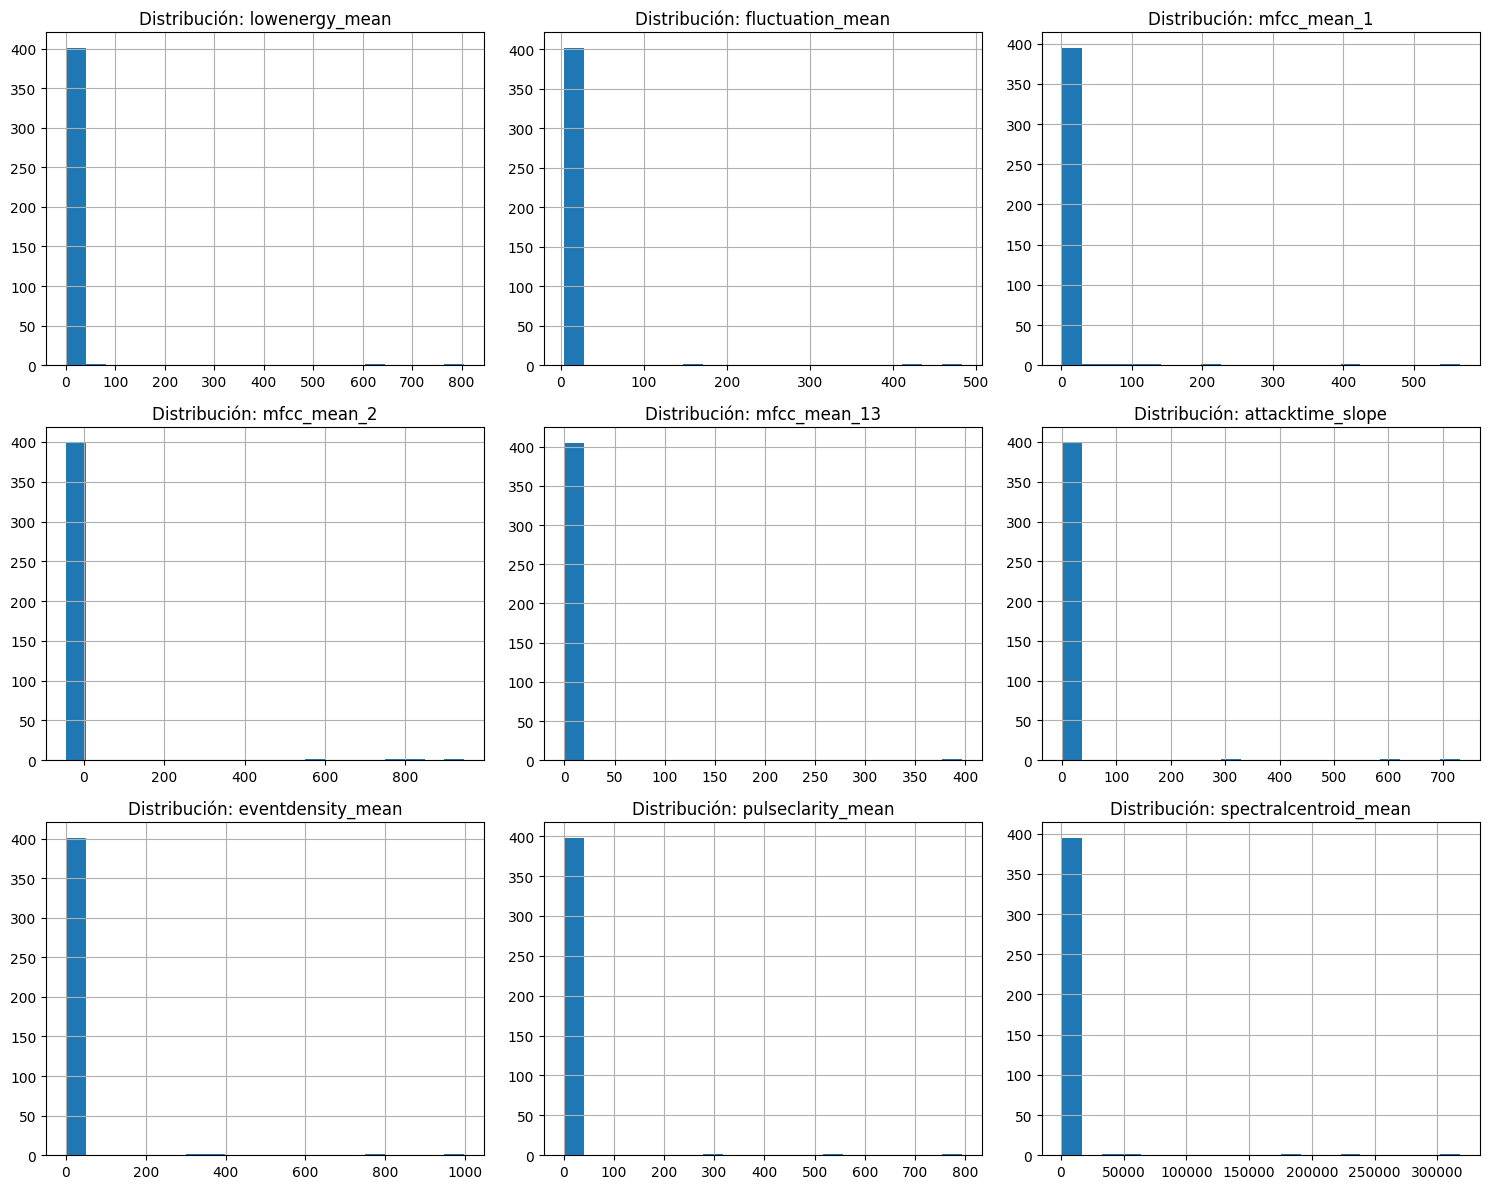

In [40]:
cols_num = [c for c in df_eda.select_dtypes(include=np.number).columns if c not in cols_id]
distribuciones_numericas(df_eda, columnas=cols_num, max_columnas=9, bins=20)

Distribuciones: categóricas

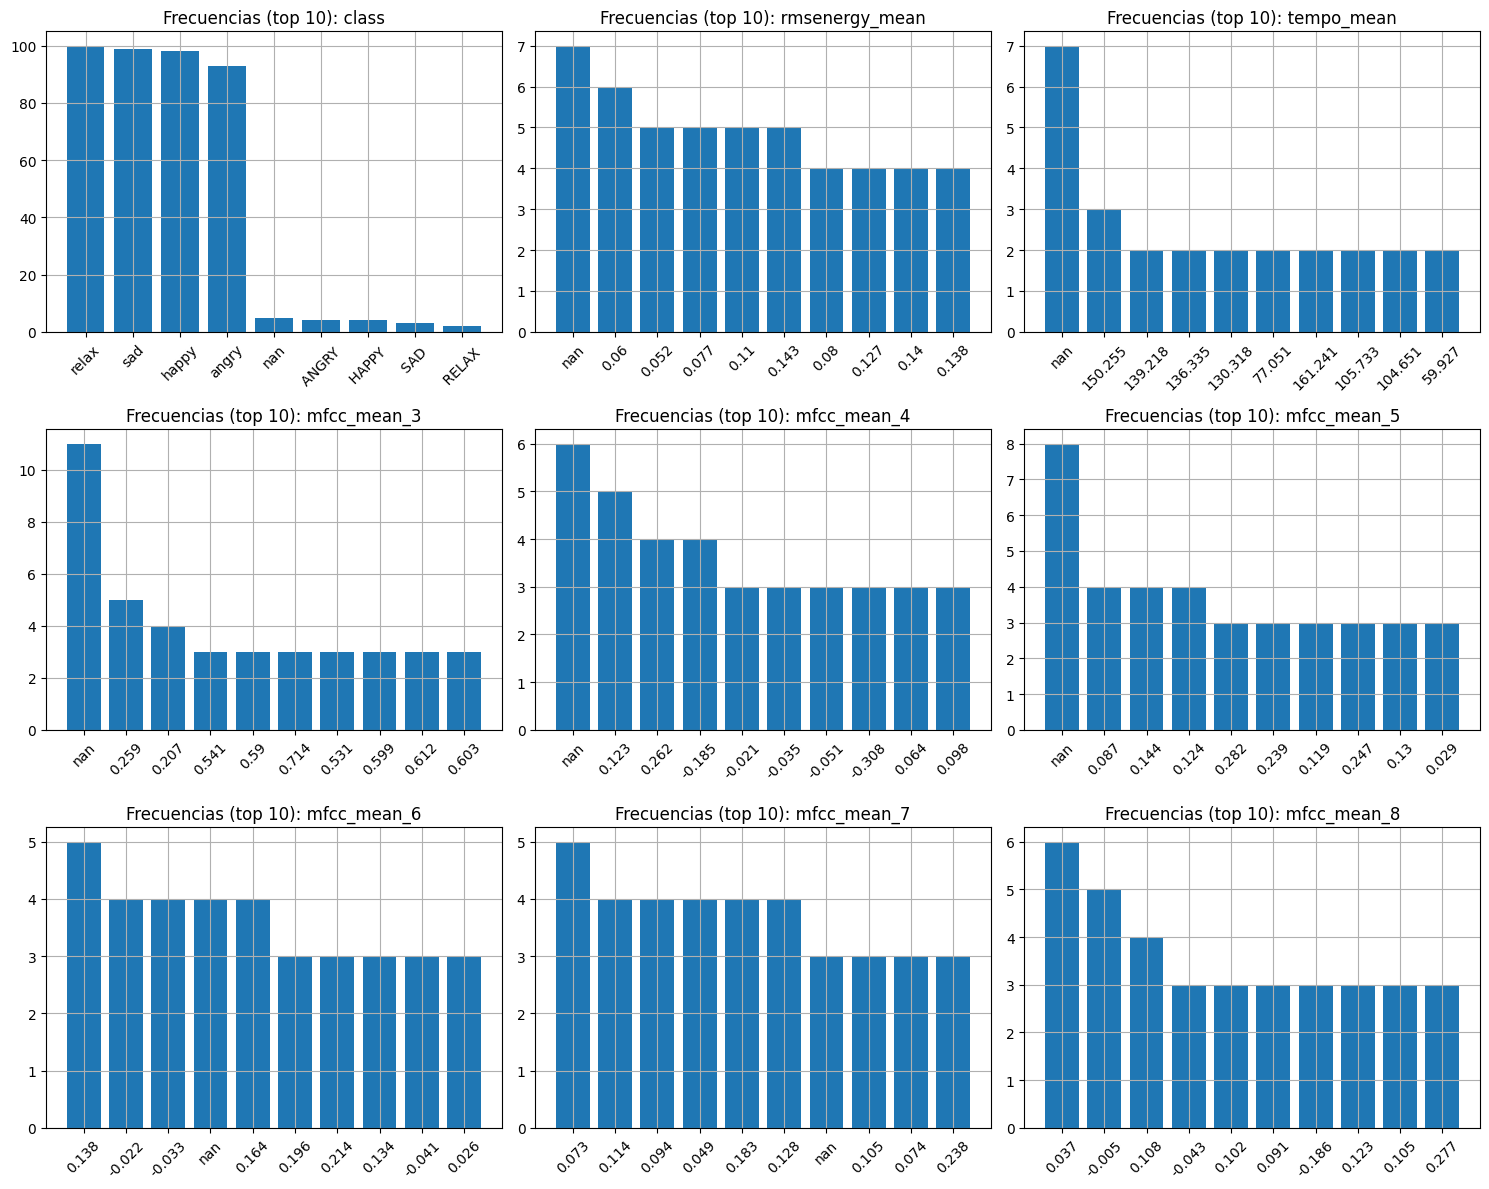

In [41]:
cols_cat = [c for c in df_eda.select_dtypes(exclude=np.number).columns if c not in cols_id]
distribuciones_categoricas(df_eda, columnas=cols_cat, top=10, max_columnas=9)

Correlación

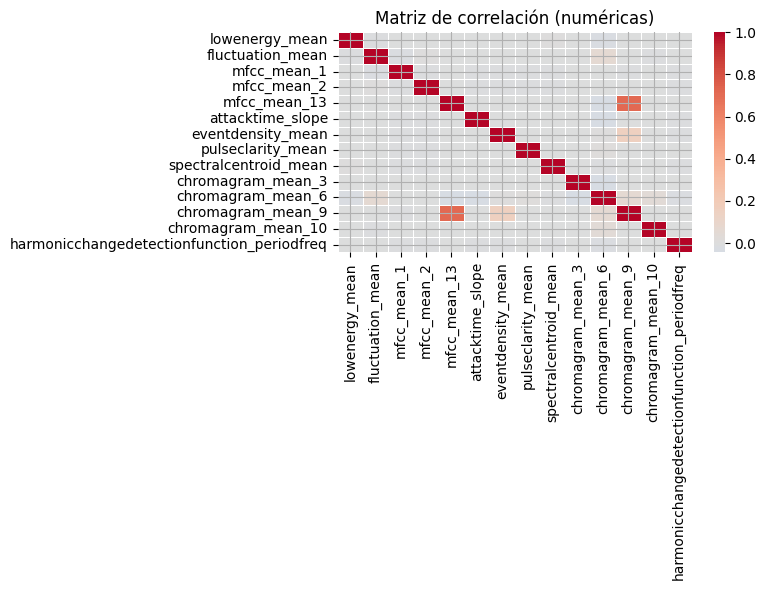

In [42]:
matriz_correlacion(df_eda, excluir=cols_id)

Outliers (solo visualización previa, sin limpiar)

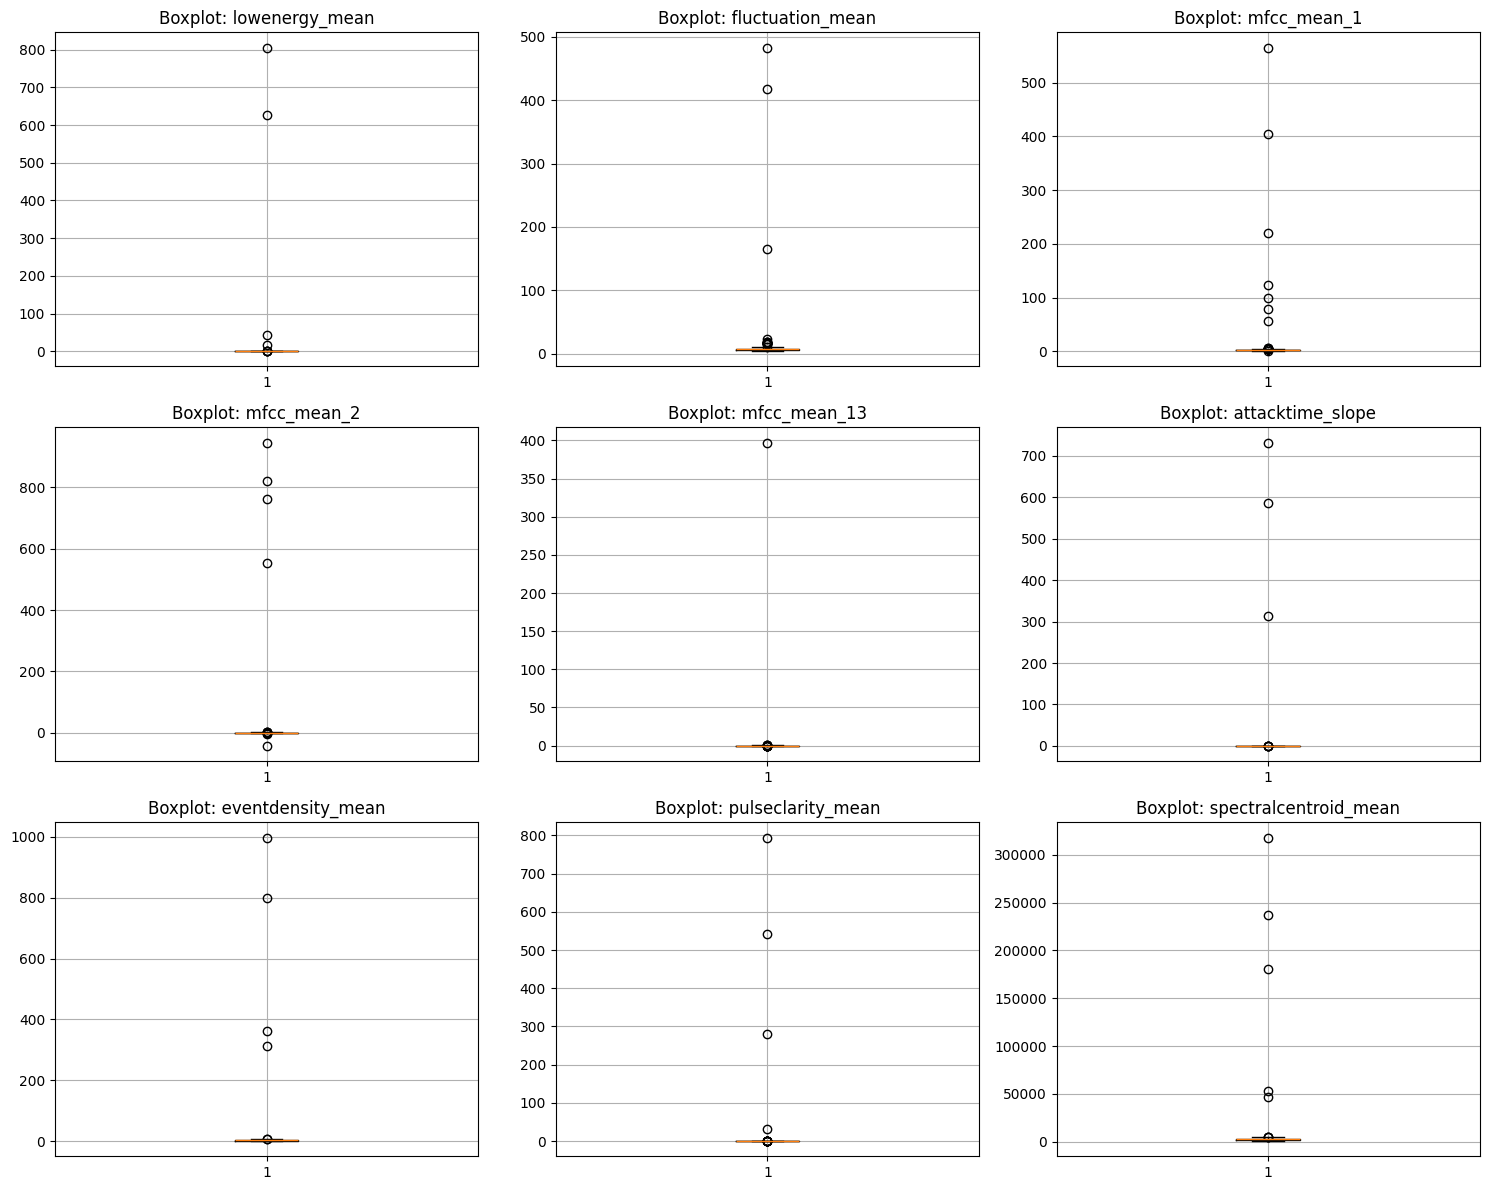

In [43]:
boxplots_outliers_previos(df_eda, columnas=cols_num, max_columnas=9)

Análisis del objetivo

Columna objetivo detectada: class

Balance de clases:


,conteo,porcentaje
class,,
relax,100,24.51
sad,99,24.26
happy,98,24.02
angry,93,22.79
NaN,5,1.23
ANGRY,4,0.98
HAPPY,4,0.98
SAD,3,0.74
RELAX,2,0.49


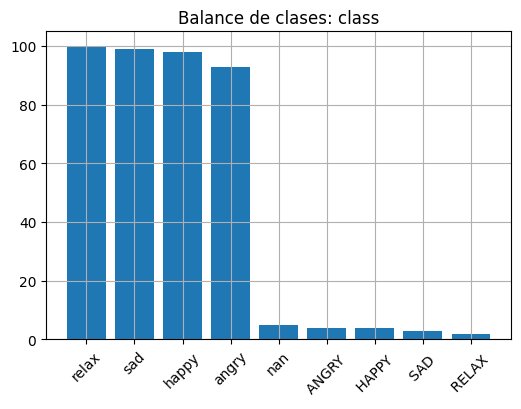

In [44]:
analisis_objetivo(df_eda, objetivo)

**Limpieza y Preparación**

Configuración y rutas

In [51]:
# Rutas de trabajo
RUTA_RAW   = Path("data/raw/turkish_music_emotion_modified.csv")
DIR_CLEAN  = Path("data/clean");  DIR_CLEAN.mkdir(parents=True, exist_ok=True)
DIR_PROC   = Path("data/processed"); DIR_PROC.mkdir(parents=True, exist_ok=True)
DIR_META   = Path("artifacts/meta"); DIR_META.mkdir(parents=True, exist_ok=True)

# Cargar el dataset crudo nuevamente (para partir de lo mismo de la EDA)
df = pd.read_csv(RUTA_RAW)
print("Dimensiones crudo:", df.shape)


Dimensiones crudo: (408, 52)


Copia “no modificada”

In [53]:
# 2.B GUARDAR COPIA "NO MODIFICADA" PARA COMPARACIÓN
RUTA_ORIGINAL = DIR_CLEAN / "dataset_original_sin_modificar.csv"
df.to_csv(RUTA_ORIGINAL, index=False, encoding="utf-8")
print("Copia no modificada guardada en:", RUTA_ORIGINAL)


Copia no modificada guardada en: data/clean/dataset_original_sin_modificar.csv


Normalización de nombres y Limpieza de strings

In [55]:
# 2.C NORMALIZAR NOMBRES Y LIMPIAR STRINGS (espacios / 'nan' / vacíos)
def normalizar_nombres_columnas(df: pd.DataFrame) -> pd.DataFrame:
    def norm(s: str) -> str:
        s = s.strip().lower()
        s = (s.replace("á","a").replace("é","e").replace("í","i")
               .replace("ó","o").replace("ú","u").replace("ñ","n"))
        s = re.sub(r'[^a-z0-9]+','_', s)
        s = re.sub(r'_+','_', s).strip('_')
        return s
    return df.rename(columns={c: norm(c) for c in df.columns})

def limpiar_textos(df: pd.DataFrame) -> pd.DataFrame:
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()
        df[c] = df[c].replace({"": np.nan, "nan": np.nan, "None": np.nan})
    return df

df = normalizar_nombres_columnas(df.copy())
df = limpiar_textos(df)
print("Nombres normalizados y textos limpiados")


Nombres normalizados y textos limpiados


Eliminar filas inválidas del objetivo y duplicados

In [56]:
# 2.E ELIMINAR REGISTROS INVÁLIDOS DE OBJETIVO Y DUPLICADOS
col_objetivo = "class"
filas_antes = len(df)
if col_objetivo in df.columns:
    df = df[~df[col_objetivo].isna()].copy()
    print(f"✔ Filas sin objetivo eliminadas: {filas_antes - len(df)}")

dup = int(df.duplicated().sum())
df = df.drop_duplicates().copy()
print("✔ Filas duplicadas eliminadas:", dup)


✔ Filas sin objetivo eliminadas: 5
✔ Filas duplicadas eliminadas: 0


Reporte de nulos

In [57]:
# 2.F REPORTE DE NULOS (ANTES DE IMPUTACIÓN)

tabla_nulos_antes = (
    df.isna().sum().to_frame("nulos")
      .assign(porcentaje=lambda t: (t["nulos"]/len(df)*100).round(2))
      .sort_values("nulos", ascending=False)
)
tabla_nulos_antes.to_csv(DIR_META / "nulos_antes.csv", encoding="utf-8")
print("Top nulos (antes):")
display(tabla_nulos_antes.head(15))


Top nulos (antes):


,nulos,porcentaje
mixed_type_col,37,9.18
mfcc_mean_11,11,2.73
mfcc_mean_3,11,2.73
mfcc_mean_5,8,1.99
spectralcentroid_mean,8,1.99
harmonicchangedetectionfunction_mean,8,1.99
mfcc_mean_12,8,1.99
tempo_mean,7,1.74
pulseclarity_mean,7,1.74
rmsenergy_mean,7,1.74


Imputación (mediana para numéricas, moda para categóricas)

In [59]:
# 2.G IMPUTACIÓN DE NULOS (mediana / moda)
num_cols = [c for c in df.select_dtypes(include=np.number).columns]
cat_cols = [c for c in df.select_dtypes(exclude=np.number).columns]

# Medianas para numéricas
medianas = df[num_cols].median(numeric_only=True)
df[num_cols] = df[num_cols].fillna(medianas)

# Modas para categóricas
modas = {}
for c in cat_cols:
    moda = df[c].mode(dropna=True)
    modas[c] = (moda.iloc[0] if not moda.empty else "desconocido")
    df[c] = df[c].fillna(modas[c])

# Guardar diccionarios de imputación (para reproducibilidad)
(DIR_META / "imputacion_medianas.json").write_text(medianas.to_json(), encoding="utf-8")
(DIR_META / "imputacion_modas.json").write_text(json.dumps(modas, ensure_ascii=False, indent=2), encoding="utf-8")

print("Imputación realizada (medianas y modas)")


Imputación realizada (medianas y modas)


Manejo de Outliers

In [61]:
# 2.H OUTLIERS: WINSORIZACIÓN POR IQR (REPORTE JSON)
def limites_iqr(s: pd.Series, k: float = 1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return (q1 - k*iqr, q3 + k*iqr)

def winsorizar_iqr(df: pd.DataFrame, columnas: list, k: float = 1.5, guardar=True):
    reporte = {}
    for c in columnas:
        serie = df[c]
        if serie.notna().sum() == 0:
            continue
        lo, hi = limites_iqr(serie, k)
        antes = int(((serie < lo) | (serie > hi)).sum())
        df[c] = serie.clip(lower=lo, upper=hi)
        despues = int(((df[c] < lo) | (df[c] > hi)).sum())
        reporte[c] = {"antes": antes, "despues": despues, "lim_inf": float(lo), "lim_sup": float(hi)}
    if guardar:
        (DIR_META / "outliers_iqr.json").write_text(json.dumps(reporte, indent=2, ensure_ascii=False), encoding="utf-8")
    return df

df = winsorizar_iqr(df, num_cols, k=1.5, guardar=True)
print("Outliers tratados por IQR (reporte en artifacts/meta/outliers_iqr.json)")


Outliers tratados por IQR (reporte en artifacts/meta/outliers_iqr.json)


Validaciones finales + guardar versión “limpia”

In [62]:

# Comprobar nulos después
tabla_nulos_despues = (
    df.isna().sum().to_frame("nulos")
      .assign(porcentaje=lambda t: (t["nulos"]/len(df)*100).round(2))
      .sort_values("nulos", ascending=False)
)
tabla_nulos_despues.to_csv(DIR_META / "nulos_despues.csv", encoding="utf-8")

print("Nulos (después) - top:")
display(tabla_nulos_despues.head(10))

# Guardar CSV/parquet limpios
RUTA_LIMPIO_CSV = DIR_CLEAN / "dataset_limpio.csv"
RUTA_LIMPIO_PAR = DIR_CLEAN / "dataset_limpio.parquet"
df.to_csv(RUTA_LIMPIO_CSV, index=False, encoding="utf-8")
df.to_parquet(RUTA_LIMPIO_PAR, index=False)

print("✅ Dataset limpio guardado en:")
print("  -", RUTA_LIMPIO_CSV)
print("  -", RUTA_LIMPIO_PAR)


Nulos (después) - top:


,nulos,porcentaje
class,0,0.0
rmsenergy_mean,0,0.0
lowenergy_mean,0,0.0
fluctuation_mean,0,0.0
tempo_mean,0,0.0
mfcc_mean_1,0,0.0
mfcc_mean_2,0,0.0
mfcc_mean_3,0,0.0
mfcc_mean_4,0,0.0
mfcc_mean_5,0,0.0


✅ Dataset limpio guardado en:
  - data/clean/dataset_limpio.csv
  - data/clean/dataset_limpio.parquet


Separación X/y y exportar para modelado

In [63]:

col_objetivo = "class"  # ajusta si corresponde
if col_objetivo in df.columns:
    y = df[col_objetivo]
    X = df.drop(columns=[col_objetivo])

    # Guardar para el punto de modelado
    (DIR_PROC / "X.csv").write_text(X.to_csv(index=False), encoding="utf-8")
    (DIR_PROC / "y.csv").write_text(y.to_csv(index=False, header=True), encoding="utf-8")
    print("✔ Archivos para modelado guardados en data/processed/: X.csv y y.csv")
else:
    print("ℹ️ No se encontró columna objetivo 'class'; omito exportación X/y.")


✔ Archivos para modelado guardados en data/processed/: X.csv y y.csv


Versionado con DVC

In [65]:

# 2.K.1 ASEGURAR QUE DVC ESTÉ INSTALADO

import importlib, sys, subprocess

def asegurar_paquete(paquete: str):
    try:
        importlib.import_module(paquete)
        print(f" {paquete} ya está instalado.")
    except ImportError:
        print(f"Instalando {paquete} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", paquete])
        importlib.invalidate_caches()
        importlib.import_module(paquete)
        print(f"{paquete} instalado.")

asegurar_paquete("dvc")


Instalando dvc ...
dvc instalado.


Versionado

In [69]:
%%bash
set -e

echo "== 2.K.2 Versionado con DVC (libreta) =="

# 1) Inicializar DVC SOLO si no existe
if [ ! -d ".dvc" ]; then
  echo "Inicializando DVC..."
  dvc init -q
else
  echo "DVC ya estaba inicializado."
fi

# 2) Asegurar que existen los archivos esperados antes de agregarlos
ls -lah data/clean || true
ls -lah artifacts/meta || true

# 3) Agregar con DVC los artefactos clave de esta fase
#    (ajusta o comenta los que no existan en tu caso)
echo "Agregando datasets y reportes a DVC..."
dvc add data/raw/turkish_music_emotion_modified.csv || true
dvc add data/clean/dataset_original_sin_modificar.csv || true
dvc add data/clean/dataset_limpio.csv || true
dvc add data/clean/dataset_limpio.parquet || true
dvc add artifacts/meta/nulos_antes.csv || true
dvc add artifacts/meta/nulos_despues.csv || true
dvc add artifacts/meta/outliers_iqr.json || true
dvc add artifacts/meta/imputacion_medianas.json || true
dvc add artifacts/meta/imputacion_modas.json || true

# (Opcional) si en 2.J guardaste X/y:
if [ -f "data/processed/X.csv" ]; then dvc add data/processed/X.csv; fi
if [ -f "data/processed/y.csv" ]; then dvc add data/processed/y.csv; fi

# 4) Si estamos en un repositorio Git, versionar .dvc y .gitignore
if git rev-parse --is-inside-work-tree >/dev/null 2>&1; then
  echo "Repositorio Git detectado: agregando y haciendo commit…"
  git add .gitignore *.dvc */*.dvc */*/*.dvc || true
  git add data/clean/*.csv.dvc data/clean/*.parquet.dvc artifacts/meta/*.dvc || true
  git add data/raw/*.csv.dvc data/processed/*.dvc || true

  git commit -m "DVC: datasets con EDA y Limpio + reportes de nulos y outliers"
else
  echo "No se detectó repositorio Git. Se omitió 'git add/commit'."
  echo "   Sugerencia: corre 'git init' y vuelve a ejecutar esta celda para trackear las .dvc con Git."
fi

echo "Listo: archivos registrados con DVC."
echo "   (Si ya tienes remoto DVC configurado, puedes 'dvc push' en otra celda.)"


== 2.K.2 Versionado con DVC (libreta) ==
DVC ya estaba inicializado.
total 412K
drwxr-xr-x 2 root root 4.0K Oct  8 19:28 .
drwxr-xr-x 5 root root 4.0K Oct  8 19:06 ..
-rw-r--r-- 1 root root 129K Oct  8 19:28 dataset_limpio.csv
-rw-r--r-- 1 root root  100 Oct  8 19:28 dataset_limpio.csv.dvc
-rw-r--r-- 1 root root 121K Oct  8 19:28 dataset_limpio.parquet
-rw-r--r-- 1 root root  104 Oct  8 19:28 dataset_limpio.parquet.dvc
-rw-r--r-- 1 root root 130K Oct  8 19:28 dataset_original_sin_modificar.csv
-rw-r--r-- 1 root root  116 Oct  8 19:28 dataset_original_sin_modificar.csv.dvc
-rw-r--r-- 1 root root   80 Oct  8 19:27 .gitignore
total 52K
drwxr-xr-x 2 root root 4.0K Oct  8 19:28 .
drwxr-xr-x 3 root root 4.0K Oct  8 19:06 ..
-rw-r--r-- 1 root root  104 Oct  8 19:28 .gitignore
-rw-r--r-- 1 root root  377 Oct  8 19:28 imputacion_medianas.json
-rw-r--r-- 1 root root  103 Oct  8 19:28 imputacion_medianas.json.dvc
-rw-r--r-- 1 root root 1.3K Oct  8 19:28 imputacion_modas.json
-rw-r--r-- 1 root roo

ERROR:  output 'data/raw/turkish_music_emotion_modified.csv' is already tracked by SCM (e.g. Git).
    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached 'data/raw/turkish_music_emotion_modified.csv'
            git commit -m "stop tracking data/raw/turkish_music_emotion_modified.csv" 
fatal: pathspec '.gitignore' did not match any files
fatal: pathspec 'data/raw/*.csv.dvc' did not match any files


**Configuracion DVC remoto**

Instalar el plugin de Azure

In [76]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "dvc-azure"])
print("dvc-azure listo")


dvc-azure listo


Configuracion de SAS de Azure

In [77]:
%%bash
set -e

# Datos de tu Azure Blob
export AZURE_STORAGE_ACCOUNT="mlopsdvc"
export AZURE_STORAGE_CONTAINER="dvcdata"
# Pega tu SAS tal cual (incluye el '?' inicial)
export AZURE_SAS_TOKEN=""

# Inicializa DVC si aún no existe la carpeta .dvc (no toca git init)
[ -d ".dvc" ] || dvc init -q

# Define/actualiza el remoto por defecto 'azdatos' apuntando al contenedor (sin subcarpeta)
REMOTE_URL="azure://${AZURE_STORAGE_CONTAINER}"
if ! dvc remote list | grep -q "^azdatos"; then
  dvc remote add -d azdatos "$REMOTE_URL"
else
  dvc remote modify azdatos url "$REMOTE_URL"
fi

# Config pública (no secreta) y SAS en config.local (no se sube a git)
dvc remote modify azdatos account_name "$AZURE_STORAGE_ACCOUNT"
dvc remote modify --local azdatos sas_token "$AZURE_SAS_TOKEN"

# Push directo al remoto
dvc push

echo "dvc push completado en azure://${AZURE_STORAGE_CONTAINER} (cuenta: $AZURE_STORAGE_ACCOUNT)"


11 files pushed
dvc push completado en azure://dvcdata (cuenta: mlopsdvc)


Push a git

In [17]:
%%bash
set -e
cd /content/Equipo1_mlops

git add fase1_avance_proyecto.ipynb
git commit -m "feat(eda): notebook con outputs para evaluación"
git push -u origin feature/eda

[feature/eda a463418] feat(eda): notebook con outputs para evaluación
 1 file changed, 1 insertion(+), 1513 deletions(-)
 rewrite fase1_avance_proyecto.ipynb (92%)
Branch 'feature/eda' set up to track remote branch 'feature/eda' from 'origin'.


To https://github.com/Pakohp88/Equipo1_mlops.git
   7b46395..a463418  feature/eda -> feature/eda
